In [10]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from transformers import AdamW, get_scheduler

from jre_utils.datapath import (
    processed_pretraining_data_paths,
    pretraining_data_paths,
    pretrained_weights_paths,
)
from jre_utils.data import TimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.engine import (
    evaluate,
    train,
    EarlyStopper,
)
from jre_utils.metrics import MSELossWeighted

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [16]:
dataset = "psm"
train_df = pd.read_csv(f"{pretraining_data_paths[dataset]}/psm_train.csv")
val_df = pd.read_csv(f"{pretraining_data_paths[dataset]}/psm_test.csv")
date_time = pd.to_datetime(train_df.pop("timestamp_(min)"))

In [17]:
train_df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24
0,0.732689,0.761748,0.606848,0.488746,0.424310,0.403609,0.519318,0.398792,0.451453,0.447077,0.463336,0.487324,0.151929,0.138458,0.201467,0.318797,0.451856,0.571500,0.469717,0.609883,0.008432,0.000000,0.481838,0.006536,0.138249
1,0.732799,0.761855,0.607133,0.488781,0.432008,0.410256,0.511364,0.402568,0.455657,0.449474,0.459267,0.494656,0.151487,0.138011,0.202110,0.321463,0.456123,0.562226,0.466533,0.629812,0.008432,0.000000,0.477218,0.006536,0.115207
2,0.732938,0.761594,0.606895,0.488791,0.418858,0.407724,0.488636,0.396526,0.456104,0.451282,0.471587,0.490333,0.153670,0.140763,0.203354,0.347219,0.456692,0.572002,0.487845,0.643598,0.006745,0.000000,0.492623,0.008715,0.092166
3,0.732893,0.761656,0.606478,0.488802,0.417896,0.404242,0.500000,0.405589,0.460020,0.456628,0.476910,0.480858,0.153426,0.141215,0.201345,0.361904,0.460532,0.563354,0.479512,0.644690,0.008432,0.000000,0.457064,0.008715,0.142857
4,0.732788,0.761573,0.606777,0.488800,0.421103,0.407407,0.511364,0.399547,0.458507,0.454611,0.451032,0.458795,0.153335,0.139718,0.203097,0.359767,0.458825,0.563354,0.448298,0.629948,0.006745,0.000000,0.472223,0.006536,0.170507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132476,0.775409,0.909234,0.606076,0.660644,0.445799,0.432099,0.494318,0.435423,0.481634,0.471902,0.470425,0.517321,0.157445,0.146511,0.206789,0.409246,0.482293,0.585537,0.392673,0.644690,0.023609,0.039146,0.145742,0.006536,0.110599
132477,0.775450,0.909155,0.606434,0.660608,0.446440,0.430199,0.477273,0.436178,0.470712,0.466382,0.460278,0.517607,0.157803,0.147555,0.209811,0.411880,0.471199,0.591929,0.388539,0.639913,0.020236,0.042705,0.150709,0.004357,0.115207
132478,0.775367,0.909096,0.606409,0.660636,0.446119,0.429566,0.488636,0.434290,0.475673,0.475423,0.462949,0.519870,0.158097,0.145823,0.208357,0.403343,0.476319,0.593182,0.389498,0.640868,0.020236,0.042705,0.152412,0.008715,0.119816
132479,0.775383,0.909189,0.606441,0.660613,0.452213,0.424501,0.482955,0.438444,0.475319,0.468606,0.462547,0.515113,0.157922,0.148171,0.205558,0.396295,0.476035,0.583532,0.389763,0.639367,0.018550,0.042705,0.153409,0.008715,0.101382


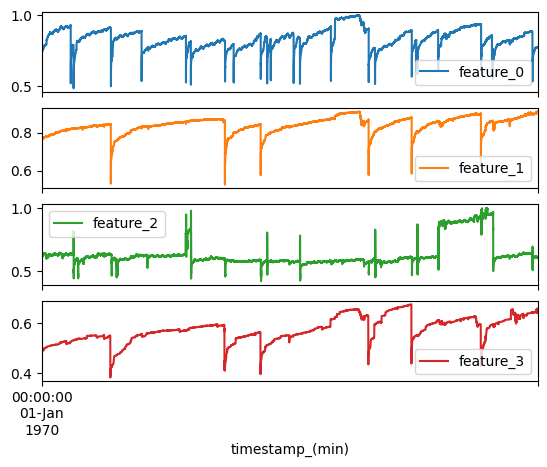

In [18]:
plot_cols = ['feature_0', 'feature_1', 'feature_2', 'feature_3']
plot_features = train_df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


In [19]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
feature_0,132481.0,0.835810,0.067326,0.486490,0.789497,0.837290,0.880603,1.000000
feature_1,132481.0,0.840205,0.039472,0.525682,0.820488,0.843873,0.866423,0.909956
feature_2,132481.0,0.634216,0.102920,0.421484,0.580170,0.603304,0.625805,1.000000
feature_3,132481.0,0.575081,0.049675,0.380874,0.543702,0.572077,0.611127,0.676682
feature_4,132279.0,0.543310,0.089438,0.065106,0.471135,0.548428,0.604875,0.929442
feature_5,132232.0,0.511753,0.077771,0.110161,0.451409,0.507439,0.559671,0.877493
feature_6,131918.0,0.549268,0.064093,0.215909,0.505682,0.539773,0.579545,1.000000
feature_7,132434.0,0.537706,0.090120,0.077795,0.470921,0.529834,0.588369,0.968278
feature_8,132434.0,0.551133,0.078996,0.038693,0.490750,0.552253,0.603570,0.935128
feature_9,132481.0,0.545177,0.081033,0.040358,0.482553,0.545577,0.598897,0.915990


In [20]:
train_df.to_csv(processed_pretraining_data_paths[dataset]["train"], index=False)
val_df.to_csv(processed_pretraining_data_paths[dataset]["eval"], index=False)

In [21]:
# df_std = (df - train_mean) / train_std
# df_std = df_std.melt(var_name='Column', value_name='Normalized')
# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
# _ = ax.set_xticklabels(df.keys(), rotation=90)

In [24]:
BATCH_SIZE = 64
window_length = 10
shift = 1

feature_columns = train_df.columns
metrics = train_df.columns

train_dataset = TimeSeriesDataset(
    train_df,
    metrics=metrics,
    feature_columns=feature_columns,
    window_length=window_length,
    shift=shift,
    transform=transforms.Compose(
        [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
    ),
)
val_dataset = TimeSeriesDataset(
    val_df,
    metrics=metrics,
    feature_columns=feature_columns,
    window_length=window_length,
    shift=shift,
    transform=transforms.Compose(
        [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
    ),
)

In [25]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
eval_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [26]:
for i, sample in enumerate(train_dataloader):
    if i == 0:
        print(i, sample["window"].shape, sample["target"].shape)
        break

0 torch.Size([64, 10, 25]) torch.Size([64, 25])


In [27]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [28]:
n_features = len(feature_columns)
target_size = len(metrics)
d_model = 128
d_hid = 256
nlayers = 4
nhead = 4
dropout = 0.1
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    target_size=target_size,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    device=device,
)
model = model.to(device)


In [29]:
n_features

25

In [30]:
model.eval()
mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        print("Loss:", loss.item())

        if i == 0:
            break

torch.Size([64, 10, 25]) torch.Size([64, 10]) torch.Size([64, 25]) torch.Size([64, 1])
torch.Size([64, 25])
Loss: 0.38953697681427


In [40]:
learning_rate = 1e-4
num_epochs = 20

In [41]:
train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [42]:
num_training_steps = num_epochs * len(train_dataloader)

optimizer = AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))
early_stopper = EarlyStopper(patience=5, min_delta=0.01)

for epoch in range(num_epochs):
    train_loss, train_r2_score = train(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)

    if early_stopper.early_stop(eval_loss):
        print(f"Early stopping at epoch {epoch}")
        break


progress_bar.close()

100%|██████████| 4900/4900 [07:14<00:00, 11.28it/s]


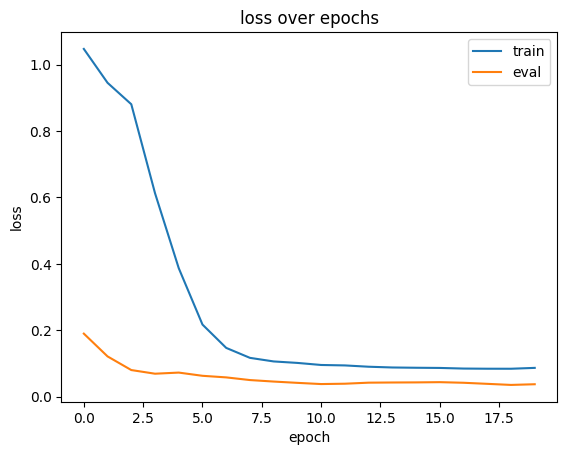

In [43]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

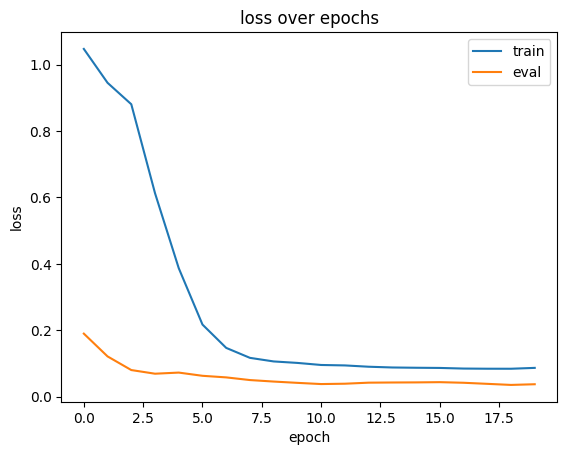

In [44]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

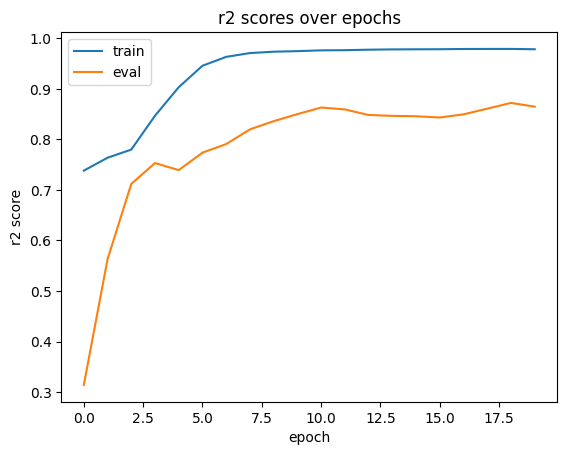

In [45]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()